# Sale Price Prediction and Segmentation of HDB Resale Flat in Singapore

### By Lee Gang

## Table of Contents

## Data Gathering And Processing

Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import re
import os
from datetime import datetime as dt
from pandas.io.json import json_normalize
import geocoder
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

### Get HDB Resale Data from Data.gov.sg

In [2]:
# Get total number of records
url_len = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=1'
max_records = requests.get(url_len).json()['result']['total']

# Extract all records from API
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit={}'.format(max_records)
results = requests.get(url).json()['result']['records']
df_hdb = pd.DataFrame(results)
df_hdb.head()


,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 21,270000,2018-07,63 years 08 months,1983,10 TO 12,1,214
1,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 21,248000,2018-07,63 years 09 months,1983,01 TO 03,2,211
2,JURONG EAST,3 ROOM,New Generation,84,JURONG EAST ST 24,318000,2018-07,63 years 07 months,1983,07 TO 09,3,241
3,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 24,305000,2018-07,66 years 11 months,1986,04 TO 06,4,250
4,JURONG EAST,3 ROOM,New Generation,67,JURONG EAST ST 24,258000,2018-07,65 years 11 months,1985,01 TO 03,5,252


In [5]:
#df_hdb.to_csv("dat_hdb.csv", index = False)

### Clean and Process HDB Dataframe

In [6]:
# Format column names
df_hdb.rename(columns = {'_id':'id'}, inplace = True)

# Format columns 'floor_area_sqm' and 'resale_price' to float
df_hdb[['floor_area_sqm', 'resale_price']] = df_hdb[['floor_area_sqm', 'resale_price']].astype(float)

# Split column 'month' to 'year' and 'month'
df_hdb['year'] = df_hdb['month'].str[0:4].astype(float)
df_hdb['month'] = df_hdb['month'].str[5:7].astype(float)

# Format column 'year' and 'lease_commencement_date' to integer
df_hdb[['year', 'lease_commence_date']] = df_hdb[['year', 'lease_commence_date']].astype(int)

# Convert 'remaining lease' into float
df_hdb['remaining_years'] = df_hdb['remaining_lease'].str[:2].astype(int)
df_hdb['remaining_months'] = df_hdb['remaining_lease'].str[9:11].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
df_hdb.loc[df_hdb['remaining_months'].isna(), 'remaining_months'] = 0
df_hdb['remaining_lease'] = df_hdb['remaining_years'] + (df_hdb['remaining_months']/12)

# Derive 'price_sqm' 
df_hdb['price_sqm'] = df_hdb['resale_price']/df_hdb['floor_area_sqm']

# Drop extra columns
df_hdb.drop(['remaining_years', 'remaining_months'], axis = 1, inplace = True)

df_hdb.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,id,block,year,price_sqm
0,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 21,270000.0,7.0,63.666667,1983,10 TO 12,1,214,2018,4029.850746
1,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 21,248000.0,7.0,63.750000,1983,01 TO 03,2,211,2018,3701.492537
2,JURONG EAST,3 ROOM,New Generation,84.0,JURONG EAST ST 24,318000.0,7.0,63.583333,1983,07 TO 09,3,241,2018,3785.714286
3,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 24,305000.0,7.0,66.916667,1986,04 TO 06,4,250,2018,4552.238806
4,JURONG EAST,3 ROOM,New Generation,67.0,JURONG EAST ST 24,258000.0,7.0,65.916667,1985,01 TO 03,5,252,2018,3850.746269


### Map and Process Street Name for Geocoding Purposes

In [19]:
# Format "street_name" column for geocoding purposes
df_hdb['street_name'] = df_hdb['street_name'].str.replace('UPP ', 'UPPER ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace(' CTRL', ' CENTRAL', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('JLN ', 'JALAN ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('BT ', 'BUKIT ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('LOR ', 'LORONG ', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace(' NTH', ' NORTH', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('KG', 'KAMPONG', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace(' DR', ' DRIVE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace('TG PAGAR', 'TANJONG PAGAR', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("C'WEALTH", 'COMMONWEALTH', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("WOODLANDS DRIVE 75", 'WOODLAND DRIVE 75', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("TAMAN HO SWEE", 'JALAN BUKIT HO SWEE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("YUNG PING RD", '157 CORPORATION DRIVE', regex = True)
df_hdb['street_name'] = df_hdb['street_name'].str.replace("YUNG LOH RD", '157 CORPORATION DRIVE', regex = True)

### Extract Coordinates via Nominatim Geocoding

**(Do Not Run: Results Have Been Saved in csv File For Easy Retrieval. Codes for First Time Execution Only. Long Processing Time)**

In [90]:
df_coord = pd.DataFrame(df_hdb['street_name'].unique())
df_coord.columns = ['street_name']
length = len(df_coord['street_name'])

In [91]:
latitude = np.zeros(length)
longitude = np.zeros(length)
address = df_coord['street_name']

for n in range(0,len(address)):
    geo = geocoder.osm(address[n] + ', SG')
    if geo.x is None:
        latitude[n] = 0
        longitude[n] = 0
    else:
        latitude[n] = geo.y
        longitude[n] = geo.x


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


In [20]:
df_coord['Latitude'] = latitude
df_coord['Longitude'] = longitude
df_coord.loc[df_coord['Latitude'].isna(), 'Latitude'] = 0
df_coord.loc[df_coord['Longitude'].isna(), 'Longitude'] = 0

print('Successfully Geocoded ' + str(df_coord[df_coord["Longitude"]!=0].shape[0]) + ' Rows')
print('Unsuccessfully Geocoded ' + str(df_coord[df_coord["Longitude"]==0].shape[0]) + ' Rows')

NameError: name 'latitude' is not defined

Save Coordinate Data to IBM Watson Studio Project

In [ ]:
from project_lib import Project
project = Project(None,"8d4e94d6-52f7-4825-a7e6-2f0dea3d0a65","p-2b42818fe02e6e4544a2dab4f2c5e2f764da1b19")
project.save_data(data=df_coord.to_csv(index=False),file_name='dat_coord.csv',overwrite=True)

Save Coordinates Dataframe to Local Drive

In [ ]:
df_coord.to_csv('dat_coord.csv', index = False)

**Retrieve Coordinates Dataframe from csv File (Geocoding Results)**

Read from Watson Studio

In [126]:
from project_lib import Project
project = Project(None,"8d4e94d6-52f7-4825-a7e6-2f0dea3d0a65","p-2b42818fe02e6e4544a2dab4f2c5e2f764da1b19")
file = project.get_file('dat_coord.csv')
file.seek(0)
df_coord = pd.read_csv(file)

Read from Local Drive

In [21]:
df_coord = pd.read_csv('dat_coord.csv')

(539, 3)

### Retrieve Nearby Venues for Each Street Using Foursquare API

Enter API keys

In [9]:
d1 = dt.today().strftime("%Y%m%d")
CLIENT_ID = 'UY1D11XDHEQYWQTVL2QKJ0AMCKA5DP5KX3RHJAKAUDCORUAL' # Foursquare Client ID
CLIENT_SECRET = 'W3CFYCNX02RVQD5MU0O2RFVNFOGONEVMGHVWZ3U3OBHPC0BC' # Foursquare Secret ID
VERSION = d1 # Foursquare API version

Define **'getNearbyVenues'** function to extract nearby venues from json

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
             
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['street_name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Compile Nearby Venues into Dataframe

In [14]:
df_venues = getNearbyVenues(names = df_coord['street_name'],
                            latitudes = df_coord['Latitude'],
                            longitudes = df_coord['Longitude'])

KeyError: 'groups'

Save file to IBM Watson Studio Project

In [161]:
project.save_data(data=df_venues.to_csv(index=False),file_name='dat_venues.csv',overwrite=True)

{'file_name': 'dat_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseraibmprofessionalcertificat-donotdelete-pr-rtwouamowuycf6',
 'asset_id': '185a4a86-0e41-46de-b38e-1c5482fb295d'}

Save file to local drive

In [72]:
df_venues.to_csv("dat_venues.csv", index = False)

**Retrieve Nearby Venues Dataframe from csv file**

Read from IBM Watson Studio Project

In [ ]:
file = project.get_file('dat_venues.csv')
file.seek(0)
df_coord = pd.read_csv(file)

Read from Local Drive

In [22]:
df_venues = pd.read_csv("dat_venues.csv")

## Feature Engineering Using Venues Data

In [23]:
# A quick view of the nearby venues dataset
df_venues.head()

,Unnamed: 0,street_name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,JURONG EAST ST 21,1.333969,103.745903,Platinum Movie Suites,1.333425,103.744113,Theater
1,1,JURONG EAST ST 21,1.333969,103.745903,Hai Di Lao 海底捞火锅 (Hai Di Lao),1.334577,103.746118,Restaurant
2,2,JURONG EAST ST 21,1.333969,103.745903,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Restaurant
3,3,JURONG EAST ST 21,1.333969,103.745903,UNIQLO,1.333175,103.743160,Clothing Store
4,4,JURONG EAST ST 21,1.333969,103.745903,Coach Factory Outlet,1.334390,103.746102,Accessories Store


### Streamline Venue Categories

Only major venue categories that might affect property prices are grouped.

In [24]:
# Bus Stops
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Bus Station', 'Bus Stop', 'Bus Line'], 
    'Bus Stop', regex = True)

# Train Stations
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Train Station', 'Metro Station', 'Light Rail Station'], 
    'Train Station', regex = True)

# Supermarkets
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Supermarket', 'Department Store', 'Convenience Store', 'Grocery Store'], 
    'Supermarket', regex = True)

# Parks
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Park', 'Lake', 'Garden', 'Other Great Outdoors'], 
    'Park', regex = True)

# Shopping Malls
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Shopping Mall', 'Shopping Plaza'], 
    'Shopping Mall', regex = True)

# Gyms
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Gym', 'Gym / Fitness Center', 'Climbing Gym', 'College Gym'], 
    'Gym', regex = True)

# Theaters
df_venues['Venue Category'] = df_venues['Venue Category'].replace(
    ['Multiplex', 'Theater', 'Movie Theater', 'Indie Theater', 'College Theater'], 
    'Theater', regex = True)

# Museums
df_venues.loc[df_venues['Venue Category'].str.contains('Museum', case=False), 'Venue Category'] = 'Museum'

# Restaurants
df_venues.loc[df_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'

### Filter venues dataframe with selected venues

In [51]:
# Create list of selected Venue Categories
venue_list = ['Bus Stop', 'Train Station', 'Supermarket', 'Park', 'Shopping Mall',
              'Gym', 'Theater', 'Restaurant', 'High School', 'General College & University',
              'Museum', 'Food Court']

# Filter venue dataframe with venue list
df_vcat = df_venues.loc[df_venues['Venue Category'].isin(venue_list),]

In [52]:
df_vcat = pd.DataFrame(df_vcat.groupby(['street_name', 'Venue Category'])['Venue'].count())
df_vcat = df_vcat.reset_index()
df_vcat = df_vcat.pivot(index='street_name',columns='Venue Category',values='Venue')
df_vcat = df_vcat.reset_index()
df_vcat.fillna(0, inplace = True)
df_vcat.head()

Venue Category,street_name,Bus Stop,Food Court,General College & University,Gym,High School,Museum,Park,Restaurant,Shopping Mall,Supermarket,Theater,Train Station
0,157 CORPORATION DRIVE,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ADMIRALTY DRIVE,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,1.0
2,ADMIRALTY LINK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,AH HOOD RD,1.0,4.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,1.0,0.0,0.0
4,ALJUNIED CRES,0.0,2.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,2.0,0.0,1.0


### Merge Venue Category And Coordinates Dataframe with HDB Dataframe

Perform One-Hot Encoding for columns "town", "flat_type", 'flat_model" and "storey_range" and merge to main dataframe.

In [54]:
df_main = df_hdb.merge(df_vcat, how = 'left', on = 'street_name')
df_onehot = pd.get_dummies(df_main[['town', 'flat_type', 'flat_model', 'storey_range']])
df_final = df_main.join(df_onehot)
df_final.drop(['town', 'flat_type','flat_model','storey_range', 'street_name', 'resale_price','id','block','lease_commence_date'], 
              axis = 1, inplace = True)
df_final.head()

,floor_area_sqm,month,remaining_lease,year,price_sqm,Bus Stop,Food Court,General College & University,Gym,High School,...,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51
0,67.0,7.0,63.666667,2018,4029.850746,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,67.0,7.0,63.750000,2018,3701.492537,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,84.0,7.0,63.583333,2018,3785.714286,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,67.0,7.0,66.916667,2018,4552.238806,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,67.0,7.0,65.916667,2018,3850.746269,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Model Building and Evaluation

### Preprocess Data for Model Building

Split Dataset into Features Set and Target Set ( X, y). The **price_sqm** will be our dependent variable.

In [92]:
y = df_final['price_sqm']
X = df_final.drop(['price_sqm'], axis = 1)

Split Dataset into training and testing sets

In [93]:
# Split datasets into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 2020)

Standardize datasets

In [94]:
scaler = StandardScaler().fit(X_train)
X_trains = scaler.transform(X_train)
X_tests = scaler.transform(X_test)

### Model Building: Extreme Gradient Boosted Trees (XGBoost)

In [83]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

# Convert datasets to XGBDMatrix
dtrain = xgb.DMatrix(X_trains, label = y_train)
dtest = xgb.DMatrix(X_tests, label = y_test)


C:\Users\admin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


**Build Default Baseline Model**

Define Model Parameters and perform cross-validation to get best 'num_boost_rounds'.

In [82]:
# Define model parameters
xgb_params = {'obj':'reg:squarederror',
              'eval_metric':'rmse',
              'max_depth':6, 
              'eta':0.5,
              'min_child_weight':1,
              'subsample':1,
              'colsample_bytree':1}

# Find model parameters 'num_boost_round' using cv
cv_res = xgb.cv(xgb_params, 
                dtrain, 
                num_boost_round=500, 
                nfold=5, 
                seed=2020, 
                stratified=False,
                early_stopping_rounds=25, 
                verbose_eval=10, 
                show_stdv=True)

# Get best num_boost_round
nrounds = cv_res[cv_res['test-rmse-mean'] == cv_res['test-rmse-mean'].min()].index[0]
cv_res[cv_res['test-rmse-mean'] == cv_res['test-rmse-mean'].min()]

[0]	train-rmse:2407.71+1.24709	test-rmse:2408.04+5.48743
[10]	train-rmse:414.846+9.59192	test-rmse:422.062+10.5247
[20]	train-rmse:341.106+6.26352	test-rmse:352.614+6.62509
[30]	train-rmse:311.637+4.47896	test-rmse:326.266+4.82879
[40]	train-rmse:292.373+1.66885	test-rmse:310.362+2.41645
[50]	train-rmse:280.044+1.81493	test-rmse:300.177+3.11109
[60]	train-rmse:270.384+2.42854	test-rmse:292.911+3.76127
[70]	train-rmse:260.726+1.32942	test-rmse:286.131+2.68542
[80]	train-rmse:253.832+1.67785	test-rmse:281.761+2.76828
[90]	train-rmse:247.359+1.56379	test-rmse:277.793+2.42791
[100]	train-rmse:241.683+1.67506	test-rmse:274.557+1.56842
[110]	train-rmse:236.923+1.6292	test-rmse:271.935+1.63096
[120]	train-rmse:232.185+1.29835	test-rmse:269.076+1.57394
[130]	train-rmse:227.594+0.899904	test-rmse:266.704+1.32041
[140]	train-rmse:223.823+0.976285	test-rmse:264.874+1.4917
[150]	train-rmse:220.188+1.12863	test-rmse:263.201+1.56663
[160]	train-rmse:216.751+0.847202	test-rmse:261.609+1.35766
[170]	t

Build Baseline XGBoost Model using model parameters and best 'num_boost_rounds' from cv.

In [73]:
# Build xgb model

xgb_def = xgb.train(params = xgb_params,
                   num_boost_round = nrounds,
                   dtrain = dtrain)

Evaluate Model Performance Using Testing Dataset

In [74]:
# Evaluate Default Model Performance Using test set

yhat = xgb_def.predict(dtest)
print('MAE: ' + str(mean_absolute_error(y_test, yhat)))
print('RMSE: '+ str(math.sqrt(mean_squared_error(y_test, yhat))))
print('R^2 Score: ' + str(r2_score(y_test, yhat)))


MAE: 161.75041474925249
RMSE: 226.5857758384587
R^2 Score: 0.9656716589179385


### Perform Randomized Grid Search for Hyper Parameter Tuning

In [97]:
# Define and setup Randomized Grid Search for Hyperparaneter Tuning

grid_params = {'max_depth': [6, 8, 10, 12],
               'min_child_weight': [1, 3, 5],
               'learning_rate': [0.1, 0.3, 0.5, 0.7], #eta
               'gamma': [0.5, 1, 1.5, 2, 5],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.8, 1.0]
              }

xgb_tune = xgb.XGBRegressor(objective = 'reg:squarederror',
                            eval_metric= 'rmse',
                            n_estimators = 500,
                            seed = 2020)

rkf = RepeatedKFold(n_splits=5, random_state = 2020)

random_search = RandomizedSearchCV(xgb_tune, 
                                   param_distributions=grid_params, 
                                   n_iter=6, 
                                   scoring='neg_root_mean_squared_error', 
                                   n_jobs=4, 
                                   cv=rkf.split(X_trains,y_train), 
                                   verbose=3, 
                                   random_state=2020)

In [108]:
# Run randomized Grid Search
#random_search.fit(X_trains, y_train)

# Show best parameters from randomized grid search
best_params = random_search.best_params_
best_params

{'subsample': 1.0,
 'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.5,
 'gamma': 2,
 'colsample_bytree': 1.0}

In [139]:

pd.DataFrame(random_search.cv_results_).to_csv("cv_results.csv", index = False)
random_search.cv_results_

{'mean_fit_time': array([201.9378663 , 279.16020909, 328.21432853, 221.4280679 ,
        437.50902885, 201.28729044]),
 'std_fit_time': array([ 3.31882047,  4.38116966,  9.216144  , 10.86356191,  8.97521798,
        24.59566986]),
 'mean_score_time': array([0.78388337, 5.92669901, 1.75349017, 0.85842921, 6.31122788,
        1.57683342]),
 'std_score_time': array([0.05372127, 0.40095602, 0.10890109, 0.07005799, 0.41852387,
        0.314575  ]),
 'param_subsample': masked_array(data=[0.6, 1.0, 0.6, 1.0, 1.0, 0.8],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 3, 5, 3, 3, 3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6, 12, 8, 6, 12, 8],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lear

In [112]:
# Modify best params dict to fit to native xgb format
best_params['eta'] = best_params['learning_rate']
del best_params['learning_rate']

# Fit xgb model with best parameters to find best 'num_boost_round' using cv
cv_tuned = xgb.cv(objective = 'reg:squarederror',
                  eval_metric= 'rmse',
                  best_params, 
                  dtrain, 
                  num_boost_round=500, 
                  nfold=5, 
                  seed=2020, 
                  stratified=False,
                  early_stopping_rounds=10, 
                  verbose_eval=10, 
                  show_stdv=True)


[0]	train-rmse:2376.46+1.72919	test-rmse:2377.02+5.15006
[10]	train-rmse:248.786+4.40851	test-rmse:289.97+2.36988
[20]	train-rmse:202.145+1.1928	test-rmse:264.523+2.58409
[30]	train-rmse:174.335+0.952029	test-rmse:254.02+2.64835
[40]	train-rmse:154.932+1.66881	test-rmse:249.28+2.95155
[50]	train-rmse:139.152+2.37525	test-rmse:245.687+2.57854
[60]	train-rmse:125.45+1.54585	test-rmse:243.258+2.73541
[70]	train-rmse:112.879+2.02078	test-rmse:241.314+2.66867
[80]	train-rmse:103.865+2.35464	test-rmse:240.483+2.86838
[90]	train-rmse:94.6232+1.8332	test-rmse:239.331+2.95393
[100]	train-rmse:87.7338+1.68329	test-rmse:238.678+3.06755
[110]	train-rmse:80.9719+0.970344	test-rmse:238.039+3.30218
[120]	train-rmse:75.226+0.88417	test-rmse:237.632+3.44306
[130]	train-rmse:70.0264+1.34704	test-rmse:237.376+3.39376
[140]	train-rmse:65.6873+1.23354	test-rmse:237.041+3.43836
[150]	train-rmse:61.5009+1.06929	test-rmse:236.83+3.46471
[160]	train-rmse:58.0729+0.784479	test-rmse:236.736+3.52009
[170]	train-r

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [0] of <class 'int'>

In [134]:
# Get best num_boost_round
cv_tuned[cv_tuned['test-rmse-mean'] == cv_tuned['test-rmse-mean'].min()]
nrounds = cv_tuned[cv_tuned['test-rmse-mean'] == cv_tuned['test-rmse-mean'].min()].index[0]
nrounds

220

In [135]:
# Build Final xgb model using tuned parameters
xgb_final = xgb.train(params = best_params,
                      num_boost_round = nrounds,
                      dtrain = dtrain)

In [140]:
xgb_final.save_model("xgb_model_final.model")

In [137]:
# Evaluate Final Model Performance Using test set
yhat = xgb_final.predict(dtest)
print('MAE: ' + str(mean_absolute_error(y_test, yhat)))
print('RMSE: '+ str(math.sqrt(mean_squared_error(y_test, yhat))))
print('R^2 Score: ' + str(r2_score(y_test, yhat)))


MAE: 127.36859886521071
RMSE: 212.80311369253315
R^2 Score: 0.9697208634286517


Text(0, 0.5, 'Feature Importance Score')

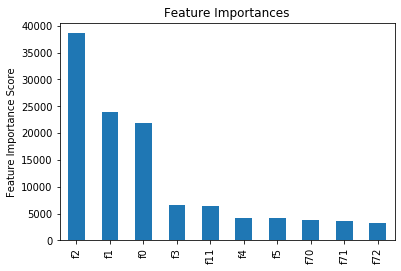

In [170]:
# Plot Feature Importance Plot
feat_imp = pd.Series(xgb_final.get_fscore()).sort_values(ascending=False)
fi_15 = feat_imp[0:10]
fi_15.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [212]:
df_fi = pd.DataFrame(pd.Series(xgb_final.get_fscore()).sort_values(ascending = False)).reset_index()
df_fi['index'] = df_fi['index'].str.extract(r'(\d+)').astype(int)
df_fi.head()

,index,0
0,2,38599
1,1,23893
2,0,21807
3,3,6550
4,11,6488


In [213]:
df_labels = pd.DataFrame(pd.Series(df_final.drop(['price_sqm'], axis =1).columns)).reset_index()
df_fi = df_fi.merge(df_labels, how = 'left', on = 'index').set_index(['index'])
df_fi.columns = ['F_score', 'Feature Name']
df_fi[0:15]

,F_score,Feature Name
index,,
2,38599,remaining_lease
1,23893,month
0,21807,floor_area_sqm
3,6550,year
11,6488,Restaurant
4,4192,Bus Stop
5,4138,Food Court
70,3879,storey_range_04 TO 06
71,3567,storey_range_07 TO 09


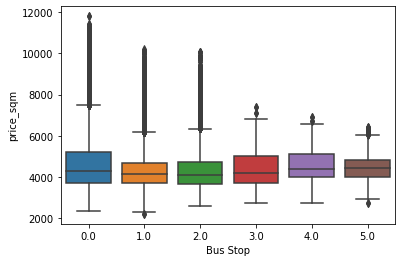

In [218]:
sns.boxplot(x = df_main['Bus Stop'], y = df_main['price_sqm'])

In [164]:
help(xgb.Booster)

Help on class Booster in module xgboost.core:

class Booster(builtins.object)
 |  Booster(params=None, cache=(), model_file=None)
 |  
 |  A Booster of XGBoost.
 |  
 |  Booster is the model of xgboost, that contains low level routines for
 |  training, prediction and evaluation.
 |  
 |  Methods defined here:
 |  
 |  __copy__(self)
 |  
 |  __deepcopy__(self, _)
 |  
 |  __del__(self)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, params=None, cache=(), model_file=None)
 |      Parameters
 |      ----------
 |      params : dict
 |          Parameters for boosters.
 |      cache : list
 |          List of cache items.
 |      model_file : string
 |          Path to the model file.
 |  
 |  __setstate__(self, state)
 |  
 |  attr(self, key)
 |      Get attribute string from the Booster.
 |      
 |      Parameters
 |      ----------
 |      key : str
 |          The key to get attribute from.
 |      
 |      Returns
 |      -------
 |      value : str
 |          The attribute v